# PCD - Homework 2

Stoica Alin-Alexandru

Simion Ruben-Andrei

MISS12

We implemented our cloud application using Google Cloud Platform.

The architecture of our Cloud Application consists of the following:

1. On-Premise Python application that generates and publishes transaction details to a Pub/Sub Component.
2. The previously mentioned Pub/Sub component.
3. A Cloud Function that subscribes to the Pub/Sub Component and saves every event(transaction) to a Firestore database Component.
4. The previously mentioned Firestore datatabase Component.
5. A Cloud Function that subscribes to the Pub/Sub Component and sends every event(transaction) to a Google Vertex AI Component and saves the ones marked as fraud in a special collection in the same database.
6. The previously mentioned Vertex AI Component which analyses every transaction for possible fraud.

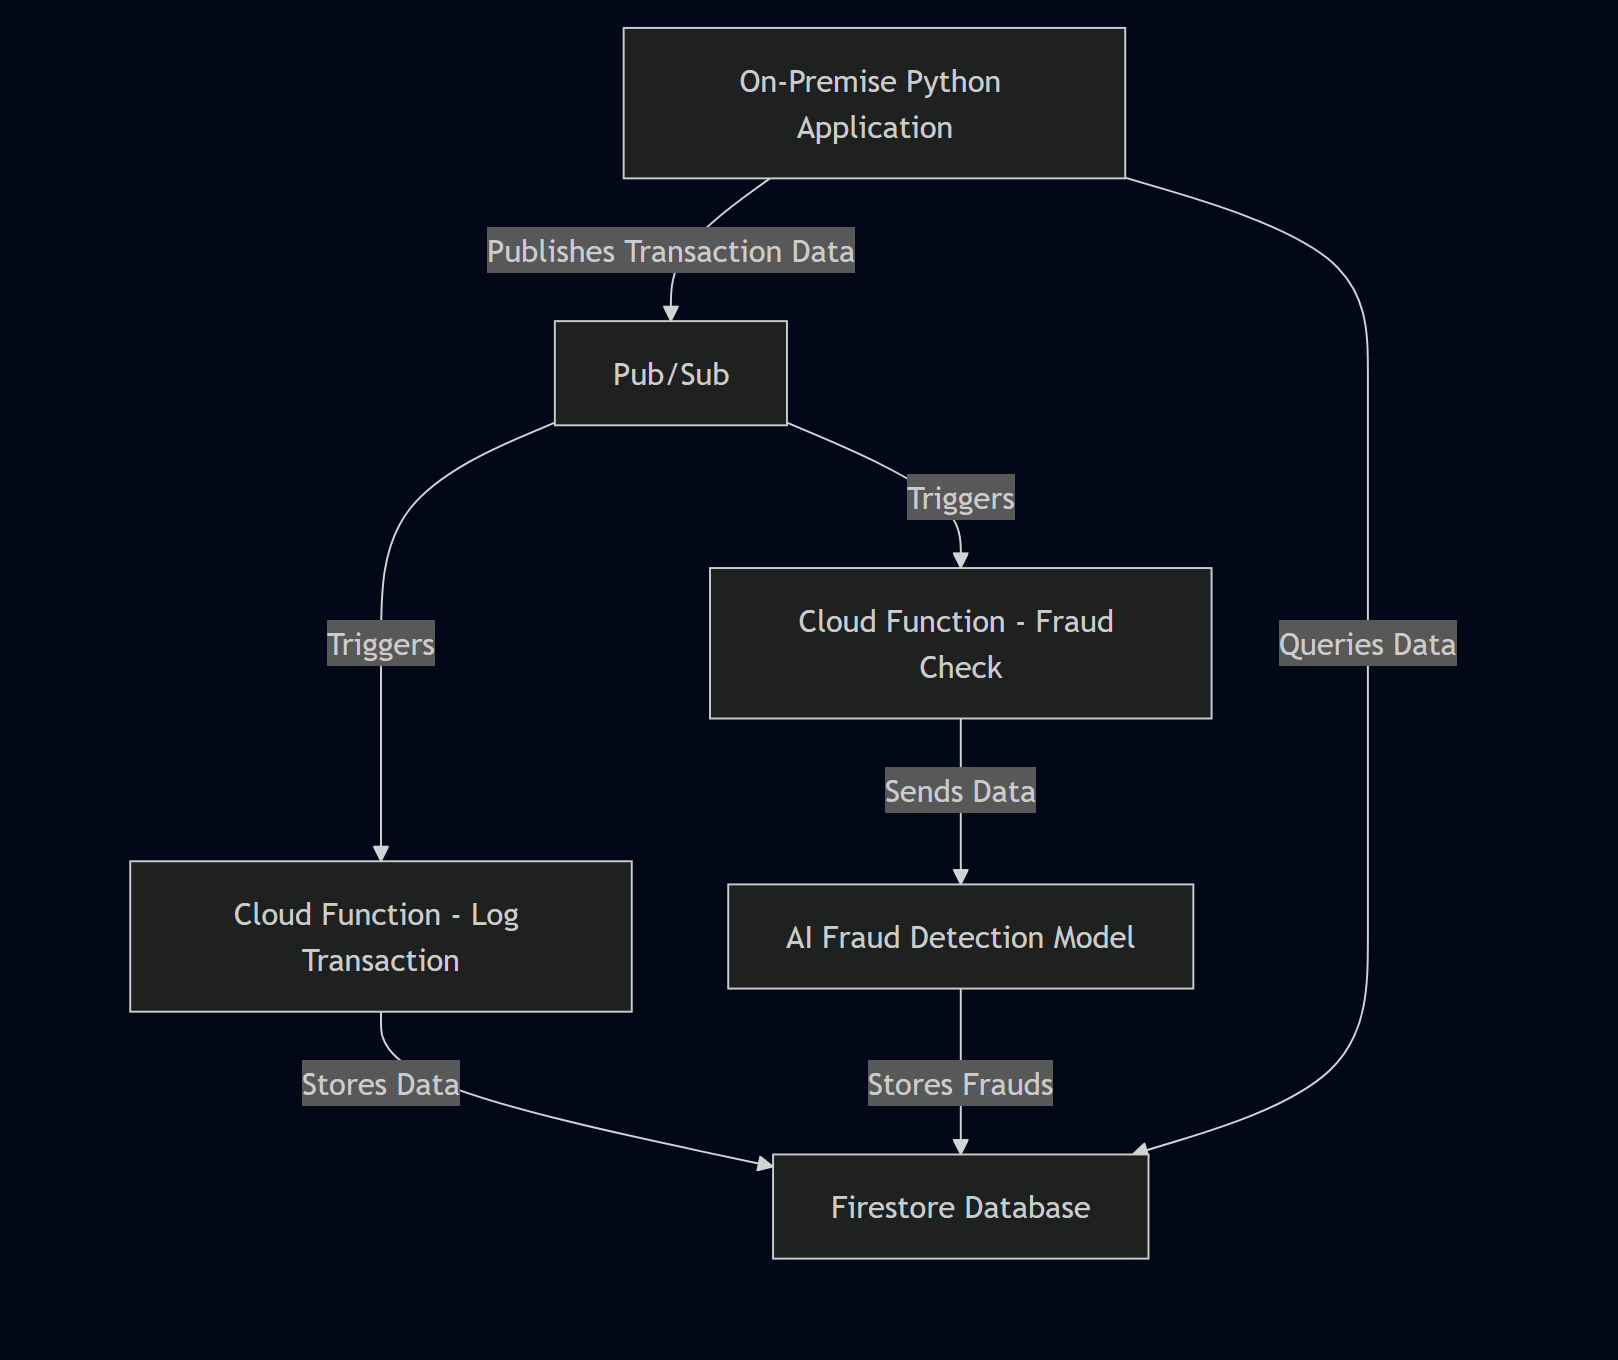

# Pub/Sub Component

Using the Pub/Sub Component, out cloud application is designed as an Event Based System, where data is published by the On-Premise application. The two previously mentioned cloud functions subscribe to this feed of data, both receive all the events without filters.

GCP Sub/Pub uses gRPC for high-performance, low-latency message delivery.

# Firestore Database


The Firestore database consists of two collections:
1. The transactions collection, which stores all the transactions received by the former cloud function mentioned above.
2. The fraud-alerts collection, which stores all the transaction marked as fraud by the latter cloud function mentioned above.

Firestore supports real-time updates using WebSockets and is Stateful.

# Google Cloud Functions

1. Firestore data logger

This function saves the transaction into a Firestore database.

In [ ]:
from google.cloud import firestore
import functions_framework
import base64
import json

# Initialize Firestore client
db = firestore.Client()

@functions_framework.cloud_event
def store_transaction(event):
    transaction = json.loads(base64.b64decode(event.data['message']['data']))
    print('decoded transaction', transaction)

    # Use card_id as document ID (or generate unique ID)
    doc_ref = db.collection("transactions").document(transaction["card_id"])

    # Store transaction data in Firestore
    doc_ref.set(transaction)

    print(f"Transaction stored in Firestore: {transaction['card_id']}")

2. Fraud checker

This function queries the model and raises an alarm if the transaction is marked as fraud

In [ ]:
from google.cloud import aiplatform, firestore
import functions_framework
import json
import base64

# Set up Firestore
db = firestore.Client()

@functions_framework.cloud_event
def detect_fraud(event):
    # Decode Pub/Sub message
    pubsub_message = base64.b64decode(event.data["message"]["data"])
    transaction = json.loads(pubsub_message)

    # Format data for Vertex AI model
    instance = {
        "amount": str(transaction["amount"]),
        "location": transaction["location"],
        "timestamp": transaction["timestamp"],
        "card_id": transaction["card_id"]
    }

    # Set up the Vertex AI
    endpoint = aiplatform.Endpoint(endpoint_name=f"<redacted>")
    # Call Vertex AI model
    prediction = endpoint.predict(instances=[instance])

    # Extract fraud score
    fraud_score = prediction.predictions[0]["scores"][1]

    if fraud_score > 0.8:
        # Store fraud alert in Firestore
        alert_ref = db.collection("fraud-alerts").document(transaction["card_id"])
        alert_ref.set({
            "transaction": transaction,
            "fraud_score": fraud_score
        })
        print(f"🚨 Fraud detected for card {transaction['card_id']} with score {fraud_score}")

# Vertex AI Component

The Vertex AI component is trained on transactions of all kinds and uses Google training method to detect anomalies. It generates a prediction probability for the transaction to be a potential fraud. This result is later evaluated and the transaction is considered fraud if the predicted result is > 0.8.

# API Overview and Statistics

The following data is reported by the Google Cloud Platform statistics:

| Name                                          | Requests | Errors (%) | Latency, median (ms) | Latency, 95% (ms) |
|-----------------------------------------------|----------|------------|----------------------|-------------------|
| Vertex AI API                                 | 1,970    | 29         | 50                   | 123               |
| Cloud Run Admin API                           | 1,305    | 1          | 44                   | 244               |
| Dataform API                                  | 1,008    | 0          | 30                   | 95                |
| Cloud Firestore API                           | 624      | 31         | 33                   | 101               |
| Cloud Logging API                             | 310      | 0          | 82                   | 126               |
| Cloud Build API                               | 171      | 1          | 50                   | 652               |
| Cloud Pub/Sub API                             | 105      | 32         | 34                   | 257               |
| Eventarc API                                  | 56       | 17         | 310                  | 943               |
| BigQuery Connection API                       | 53       | 0          | 48                   | 102               |
| Identity and Access Management (IAM) API      | 22       | 0          | 48                   | 63                |
| Artifact Registry API                         | 18       | 5          | 40                   | 63                |
| Cloud Datastore API                           | 11       | 18         | 49                   | 113               |
| Cloud Dataplex API                            | 2        | 0          | 1,572                | 2,044             |